### Mahmoud Mohamed Taha             
### mahmoudtaha613@gmail.com

# Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
#from sklearn.feature_extraction import text 
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from joblib import dump, load

# 1) - Loading Data

In [2]:
df = pd.read_csv('../02_Documents/Job titles and industries.csv')
df.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


# 2) - Data Exploration

Shape : (8586, 2)
Nulls : 0
Duplicates : 4618
Targets: ['IT' 'Marketing' 'Education' 'Accountancy']
IT             4746
Marketing      2031
Education      1435
Accountancy     374
Name: industry, dtype: int64


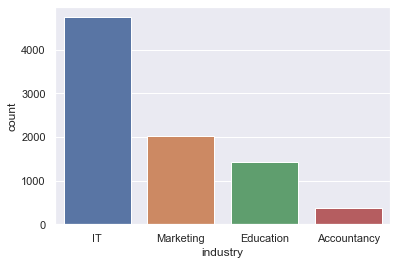

In [3]:
print('Shape :',df.shape)
print('Nulls :' , df.isnull().sum().sum())
print('Duplicates :',df.duplicated().sum())
print('Targets:', df.industry.unique())
print(df.industry.value_counts())
ax = sns.countplot(df.industry) 


## duplication
there is lots of duplicate in the data instances (job titles) about 4618 record
<br>
since our data doesn't have ID so we will treat this duplicates as if they were comeing from different resourcesand adding more confidence to our model
<br>
so will not drop them

In [4]:
#check duplications
df[df.duplicated()]

,job title,industry
7,devops engineers x 3 - global brand,IT
10,devops engineers x 3 - global brand,IT
11,devops engineers x 3 - global brand,IT
26,business analyst,IT
36,.net developer,IT
...,...,...
8572,telesales agent,Marketing
8575,sales manager,Marketing
8576,marketing & social media specialist,Marketing
8580,marketing specialist,Marketing


# 3) - Cleaning the data and preparing for model.

In [5]:
#let's take a look to see if our data needs to be cleaned
df['job title'].sample(10)

4985                           junior conference producer
8377                                     printer operator
7562       [teaching] impact india- english teaching gt/s
7331           payment specialist / payment administrator
118                      product manager - sports trading
810             senior solutions engineer, infrastructure
1308                             full stack php developer
4891                       seo senior marketing executive
6279    principal early childhood educator braehead pr...
975                                  lead devops engineer
Name: job title, dtype: object

## Punctuation Removal
our data have alots of Punctuations in it and some of them have meaning like:
<br>
++ # having meaning if they coming after letter c as they are programming languages c++ and c# and . to in .net
<br>
so before removing Punctuations we handled the ++ and # and . problem by replace them by meaningful words
<br>
 C# >> csharp<br>
 C++ >> Cplusplus<br>
 .net >>dotnet

In [6]:
#get rows containing Punctuations
df['job title']= df['job title'].apply(lambda x: x.lower()) #Lowering the text
df[df['job title'].str.contains('[^\w\s]+')].drop_duplicates()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
6,devops engineers x 3 - global brand,IT
9,"php web developer £45,000 based in london",IT
12,solution / technical architect - ethical brand,IT
13,lead developer - ethical brand,IT
...,...,...
8573,business development specialist (part-time),Marketing
8574,sales account manager (part-time),Marketing
8583,sales & marketing manager,Marketing
8584,marketing & digital marketing consultant,Marketing


In [7]:
df[df['job title'].str.contains('(c\#|c\+\+|\.net)+')].drop_duplicates()

,job title,industry
15,"vb .net web developer, milton keynes, £45k",IT
20,"c# software developer, waltham cross, £55k",IT
33,.net developer,IT
98,software developer - c# .net javascript,IT
114,senior .net developer,IT
...,...,...
5938,graduate software engineer - c++ computer vision,IT
5943,graduate software engineer - java/c++/c#,IT
5948,firmware engineer - c/c++,IT
5975,"software developer - .net, c#",IT


In [8]:
df['job title'] = df['job title'].str.replace("c\#","csharp")
df['job title'] = df['job title'].str.replace("c\+\+","cplusplus")
df['job title'] = df['job title'].str.replace("\.net","dotnet")
assert df['job title'].str.contains('(c\#|c\+\+|\.net)+').any() == False #making sure that we replaced .net c# and c++

## Salary Removal
Some of our data have salary written in it so we removed that salary form all rows as it isn't job title related information

In [9]:

df['job title'] = df['job title'].str.replace('[^\w\s]|£|\dk|\d',' ')
df['job title'] = df['job title'].str.replace('(\sk\s)',' ')
print(df[df['job title'].str.contains('(\sk\s)')])
assert df['job title'].str.contains('[^\w\s]|£|\d').any() == False  #making sure that removed salary
assert df['job title'].str.contains('(\sk\s)').any() == False  #making sure removed k that came after salary 40,00k

Empty DataFrame
Columns: [job title, industry]
Index: []


In [10]:
df['job title'].sample(10)

3154                                        product owner
320     informatica developer   migration  dwh  oracle...
1401    enterprise mobility   security   office     en...
7085                                    chemistry teacher
5363    junior researcher   qualitative   quantitative...
7552                                       french teacher
3075                               product innovation sme
6456        primary and secondary teachers   saudi arabia
4980                    paid search account manager   ppc
3259                         information security manager
Name: job title, dtype: object

## Tokenization
In this step, the text is split into words

In [11]:
def tokenization(text):
    tokens = re.split('\W\s*',text)
    return tokens

#applying function to the column
df['job title']= df['job title'].apply(lambda x: tokenization(x))

## Stop word removal
I have used NLTK stop words list as these words don't add any value to our test
<br>
in addition to nltk stopwords i have add some additional words that i have spoted during exploring our data like :
<br>
per day, up to ,must be ,per hr,months,salary , doe,month ,part time,trainee,internship,year ,monthes,part-time
<br>
and i have also spoted that there are some records have UK cites writen in the job title and that not related to specific job
<br>
UK cites data source : https://simplemaps.com/data/gb-cities
<br>
so i have updated stopwords array and used it to remove unwanted words from our data 

In [12]:
nltk.download('stopwords') #make sure we have latest version from stopwords 
#get all cities names from external data source 
gb = pd.read_csv('../02_Documents/gb.csv')
city = gb.city.apply(lambda x: x.lower()).tolist() #get the city column from data set
stopwords = nltk.corpus.stopwords.words('english')
unnecessary_words = ['per',
                     'up',
                     'hr',
                     'months',
                     'salary',
                     'time',
                     'trainee',
                     'internship',
                     'year',
                     'part',
                     'day',
                     'month',
                     'head',
                     'required',
]
stopwords = stopwords + city + unnecessary_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\M-Taha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

df['job title']= df['job title'].apply(lambda x:remove_stopwords(x)) #replace none job related words with space


## Lemmatization: 
i have tried to use Lemmatization but our data have alots of abbreviations like it, js,bi 
so i didn't use it to save this abbreviations

In [14]:
# from nltk.stem import WordNetLemmatizer
# #defining the object for Lemmatization
# wordnet_lemmatizer = WordNetLemmatizer()
# def lemmatizer(text):
#     lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
#     return lemm_text
# df['job title']=df['job title'].apply(lambda x:lemmatizer(x))

In [15]:
#join our data again to use it with CountVectorizer and TfidfTransformer 
df['job title'] = [" ".join(review) for review in df['job title'].values] 
df['job title']

0       technical support helpdesk supervisor county b...
1                       senior technical support engineer
2                                                services
3                                   js front end engineer
4                            network telephony controller
                              ...                        
8581                                     data entry clerk
8582                                      content creator
8583                              sales marketing manager
8584               marketing digital marketing consultant
8585                  creative copywriter arabic english 
Name: job title, Length: 8586, dtype: object

# splitting the data
i have splited our data into 20 % validation set and 80 % training and test sets 
<br>
i have stratifed our target data to save data distribution 

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(df['job title'], df.industry , test_size = 0.2, random_state = 0,stratify = df.industry)

# Dealing with Data Imbalance
i have used SMOTEN package to balance the dataset a little by oversampling {'Accountancy'}
i have added the smote step in model pipeline
and also added sample weights to the classifier when training to further solve this issue of imbalance.


# 4) Model Training
for the training phase i have created 3 pipelines with three models SGDClassifier, LinearSVC and LogisticRegression
<br>
each pipeline have four steps CountVectorizer, TfidfTransformer, SMOTE and the model
<br>
i have used GridSearchCV to get insights about each model performance


In [17]:
models = {'sgd':SGDClassifier(class_weight = 'balanced'),'lsvc' : LinearSVC(class_weight = 'balanced'),
          'logr' : LogisticRegression(class_weight = 'balanced', max_iter = 200)}
scores = {}
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
}
for key,model in models.items():
    pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('smote',SMOTE(sampling_strategy={'Accountancy':1000})),
    ('clf', model),
    ])
    grid_search = GridSearchCV(pipeline,parameters, n_jobs=-1, verbose=1,scoring  = 'f1_weighted')
    grid_search.fit(X_train, y_train)
    scores[key] = grid_search.best_score_
print(scores)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'sgd': 0.9284138990246733, 'lsvc': 0.9288448063517094, 'logr': 0.9250110504432406}


[(0.9, 0.96)]

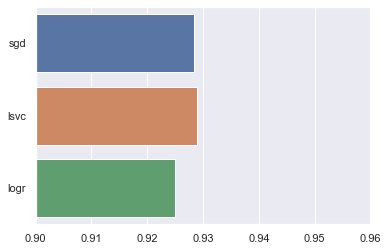

In [18]:
ax = sns.barplot(list(scores.values()),list(scores.keys()),orient = 'h') 
ax.set(xlim=(.9, .96))


# Model Tuning
i have chosen LinearSVC as it have high score with sgd , fast  and it's not needing alot of hyper-parameter tuning
<br>
and as often text data are linearly separable

In [19]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__intercept_scaling' : (.9,.8,.7),
}

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('smote',SMOTE(sampling_strategy = {'Accountancy':1000})),
    ('clf', LinearSVC(class_weight = 'balanced')),
])


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,scoring  = 'f1_weighted')
print("Performing grid search...")
grid_search.fit(X_train, y_train)
print()
print("Best score: %0.3f" % grid_search.best_score_)

Performing grid search...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best score: 0.938


In [20]:
labels = grid_search.predict(X_valid) #predict valiation data

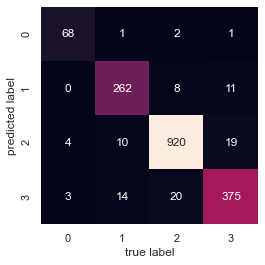

In [21]:
mat = confusion_matrix(y_valid, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [22]:
print(metrics.classification_report(y_valid, labels, target_names=df['industry'].unique()))

              precision    recall  f1-score   support

          IT       0.94      0.91      0.93        75
   Marketing       0.93      0.91      0.92       287
   Education       0.97      0.97      0.97       950
 Accountancy       0.91      0.92      0.92       406

    accuracy                           0.95      1718
   macro avg       0.94      0.93      0.93      1718
weighted avg       0.95      0.95      0.95      1718



## Model Evaluation
i have decided to use f1 _ weighted as evaluation metric
<br>
as it takes into account how the data is distributed
<br>
useful when you have data with imbalance classes as in our case

In [23]:
print('f1_score %s' % f1_score(y_valid, labels,average = 'weighted'))

f1_score 0.9458407496641162


In [24]:
dump(grid_search, 'model.joblib')

['model.joblib']